# Importing Dataset

In [ ]:
!pip install opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/ambarish/breakhis'
od.download(dataset_url)

100%|██████████| 3.99G/3.99G [01:22<00:00, 52.0MB/s]


# Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os, time, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import tensorflow as tf 
from functools import partial

In [ ]:
# import keras
from tensorflow.keras import layers
import albumentations as A
import tensorflow_hub as hub
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import KFold

In [ ]:
image_dir = '/content/breakhis/BreaKHis_v1'
data_path = '/content/breakhis/Folds.csv'

# experimental API for making data pipelines
tf.data.experimental.AUTOTUNE

# defining the class names
class_names = ['A', 'F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']
print(class_names)

['A', 'F', 'PT', 'TA', 'DC', 'LC', 'MC', 'PC']


In [ ]:
# loading the data
data = pd.read_csv(data_path)
data.head(5)

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [ ]:
data = data.rename(columns={'filename': 'path'})
data['filename'] = data.path.apply(lambda x: x.split('/')[-1])
data['label'] = data.filename.apply(lambda x: x.split('_')[2].split('-')[0])
data['label_int'] = data.label.apply(lambda x: class_names.index(x))

In [ ]:
data.head(6)

,fold,mag,grp,path,filename,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,A,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,A,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,A,0
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-004.png,A,0
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-005.png,A,0
5,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-006.png,A,0


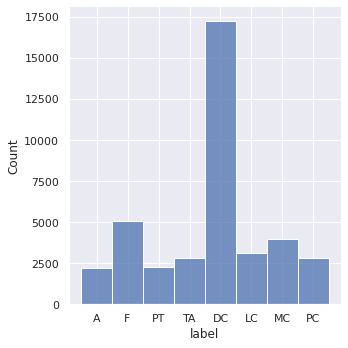

In [ ]:
sns.set_theme()
sns.displot(x='label', data=data)

There are marginally higher number of samples in DC as compared to others.

In [ ]:
len(data[data.label_int==0]), len(data[data.label_int==1]), len(data[data.label_int==2]), len(data[data.label_int==3]), len(data[data.label_int==4]), len(data[data.label_int==5]), len(data[data.label_int==6]), len(data[data.label_int==7]),  

(2220, 5070, 2265, 2845, 17255, 3130, 3960, 2800)

In [ ]:
df2 = data.drop(data[data['label_int'].eq(4)].sample(14255).index)
df1 = df2.drop(df2[df2['label_int'].eq(1)].sample(2000).index)
df = df1.drop(df1[df1['label_int'].eq(6)].sample(900).index)

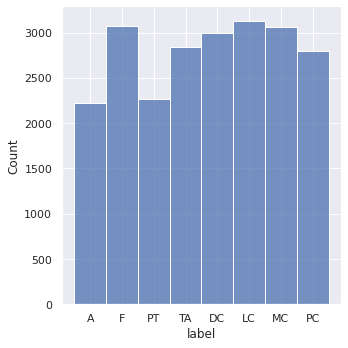

In [ ]:
sns.set_theme()
sns.displot(x='label', data=df)

In [ ]:
data = df

In [ ]:
data

,fold,mag,grp,path,filename,label,label_int
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-001.png,A,0
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,A,0
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,A,0
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-004.png,A,0
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-005.png,A,0
...,...,...,...,...,...,...,...
39540,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,SOB_M_PC-15-190EF-400-011.png,PC,7
39541,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,SOB_M_PC-15-190EF-400-012.png,PC,7
39542,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,SOB_M_PC-15-190EF-400-013.png,PC,7
39543,5,400,test,BreaKHis_v1/histology_slides/breast/malignant/...,SOB_M_PC-15-190EF-400-014.png,PC,7


# Splitting data into train, test and validation set

In [ ]:
test_images = data.groupby(by='label').sample(500)
train_images = data.drop(test_images.index).reset_index(drop=True)
test_images = test_images.reset_index(drop=True)

In [ ]:
# making splits of training & validation datasets
validation_images = train_images.sample(frac = 0.3)
train_images = train_images.drop(validation_images.index).reset_index(drop=True)
validation_images = validation_images.reset_index(drop=True)

In [ ]:
print('Total training images: % s' % str(train_images.shape[0]))
print('Total validation images: % s' % str(validation_images.shape[0]))
print('Total testing images: % s' % str(test_images.shape[0]))

Total training images: 12873
Total validation images: 5517
Total testing images: 4000


In [ ]:
train_images['set'] = 'train'
validation_images['set'] = 'validation'
test_images['set'] = 'test'

In [ ]:
new_data = pd.concat([train_images, validation_images, test_images])
new_data.head(5)

,fold,mag,grp,path,filename,label,label_int,set
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-002.png,A,0,train
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-003.png,A,0,train
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-004.png,A,0,train
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-006.png,A,0,train
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-009.png,A,0,train


In [ ]:
#unsampling data
max_count = np.max(train_images.label.value_counts())
min_count = np.min(train_images.label.value_counts())
train_images = train_images.groupby('label').sample(n=max_count, replace=True)
train_images = train_images.reset_index(drop=True)

In [ ]:
train_images

,fold,mag,grp,path,filename,label,label_int,set
0,2,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549CD-200-028.png,A,0,train
1,2,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549CD-400-030.png,A,0,train
2,2,100,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549G-100-019.png,A,0,train
3,3,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-013.png,A,0,train
4,2,40,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549G-40-034.png,A,0,train
...,...,...,...,...,...,...,...,...
14675,2,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_TA-14-16184-100-026.png,TA,3,train
14676,4,400,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_TA-14-19854C-400-007.png,TA,3,train
14677,5,200,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_TA-14-3411F-200-010.png,TA,3,train
14678,5,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_TA-14-15275-100-004.png,TA,3,train


In [ ]:
train_images.head(5)

,fold,mag,grp,path,filename,label,label_int,set
0,2,200,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549CD-200-028.png,A,0,train
1,2,400,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549CD-400-030.png,A,0,train
2,2,100,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549G-100-019.png,A,0,train
3,3,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549AB-100-013.png,A,0,train
4,2,40,test,BreaKHis_v1/histology_slides/breast/benign/SOB...,SOB_B_A-14-22549G-40-034.png,A,0,train


# Model

In [ ]:
model_handle_map = {"inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"}
#https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5
model_image_size = {"inception_resnet_v2": 299}

In [ ]:
# function to decode a PNG image into a tf tensor
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_png(image, channels=3)
    return image, label

# reshaping the image between 0 and 1
def image_reshape(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224] / 255)
    return image, label

def argument_image(image):
    transform = A.Compose([A.HorizontalFlip(p = 0.5), 
                          A.Rotate(p = 0.5, limit = 15), 
                          A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.1, 0.1)),
                          #A.RandomResizedCrop(p=0.8, height=IMG_SIZE, width=IMG_SIZE, 
                                              #scale=(0.9, 1.1), ratio=(0.05, 1.1), interpolation=0),
                           A.Blur(blur_limit = (1, 1))
                           
                          ])
    
    data = {"image": image}
    argumented_data = transform(**data)
    argumented_image = argumented_data["image"]
    argumented_image = tf.cast(argumented_image, tf.float32)
    argumented_image = tf.image.resize(argumented_image, [IMG_SIZE, IMG_SIZE]) / 255
    
    return argumented_image

def argumentor_function(image, label):
    argumented_image = tf.numpy_function(func = argument_image, inp=[image], Tout = tf.float32)
    return argumented_image, label


# function to view sample of images
def view_image(ds, col = 5, row = 5, size=(30, 10)):
    plt.figure(figsize=(10, 5))
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for images, labels in ds.take(1):
        for i in range(col * row):
            ax = plt.subplot(row, col, i + 1)
            shape = str(images[i].numpy().shape)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i].numpy()])
            plt.axis("off") 
    plt.tight_layout
    return None

def view_model_predictions():
    plt.figure(figsize = (30, 8))
    plt.rcParams.update({'font.size': 10})
    plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    for i in range(30):
        ax = plt.subplot(3, 10, i + 1)
        shape = str(test_image[i].numpy().shape)
        plt.imshow(test_image[i].numpy())
        plt.title(predicted_label[i][0])
        plt.axis("off") 
        plt.tight_layout
    return None

# making a function to calculate & show model history
def model_hist(history):
    accuracy = history['accuracy']
    loss = history['loss']
    val_accuracy = history['val_accuracy']
    val_loss = history['val_loss']
    
    # setting the epochs
    n_epochs = range(len(history['loss']))
    
    # saving models logs
    # csv_logger = CSVLogger('cnn_model_logs.csv', append=True)
    
    # making plots for accuracy 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_epochs, accuracy, label='training accuracy')
    plt.plot(n_epochs, val_accuracy, label='validation accuracy')
    plt.legend()
    
    # making plots for loss
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, loss, label='training loss (binary crossentropy)')
    plt.plot(n_epochs, val_loss, label='validation loss (binary crossentropy)')
    plt.legend()
    
    return None

# function for decoding a test image
def decode_test_img(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

In [ ]:
# defining model configuration parameters
model_name = "inception_resnet_v2"
model_handle = model_handle_map.get(model_name)
IMG_SIZE = model_image_size.get(model_name, 299)
BATCH_SIZE = 32
sample_size = len(train_images)

print(f"Selected model: {model_name} : {model_handle}")
print(f"Input size of model: {IMG_SIZE}")


Selected model: inception_resnet_v2 : https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5
Input size of model: 299


In [ ]:
(image_dir + '/' +train_images.path)[0]

'/content/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549CD/200X/SOB_B_A-14-22549CD-200-028.png'

In [ ]:
# loading the train & validation dataets
load_train = tf.data.Dataset.from_tensor_slices((image_dir + '/' + train_images.path, 
                                                train_images.label_int))

load_valid = tf.data.Dataset.from_tensor_slices((image_dir + '/' + validation_images.path, 
                                                validation_images.label_int))

In [ ]:
load_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
BATCH_SIZE = 32
train_dataset = (
                load_train.shuffle(len(train_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )
val_dataset = (
                load_valid.shuffle(len(validation_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Time Taken: 2.384 seconds


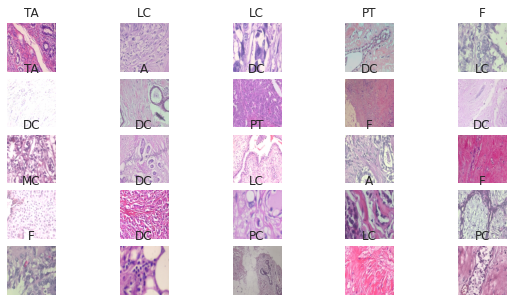

In [ ]:
start = time.time()
view_image(train_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

Time Taken: 2.232 seconds


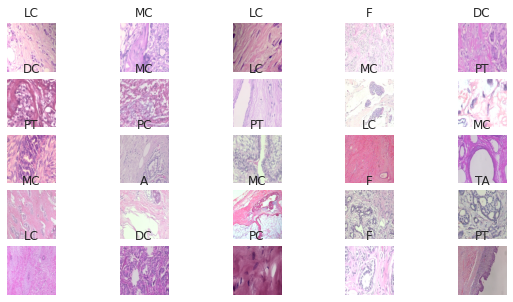

In [ ]:
start = time.time()
view_image(val_dataset)
end = time.time()
print('Time Taken: %.3f seconds' % (end-start))

In [ ]:
width, height, channels = 299, 299, 3
classes = 8
from tensorflow.keras.applications import InceptionResNetV2
model=InceptionResNetV2(include_top=True,
                      weights=None,
                      input_tensor=None,
                      pooling='avg',
                      input_shape=(width, height, channels),
                      classes=classes)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True)

# model logs
csv_logger = CSVLogger('cnn_model_logs.csv', append=True)

metrics = ['accuracy', Precision(name='Precision'), Recall(name='Recall')]

model.fit_generator(train_dataset, epochs=25, verbose=1,callbacks=[model_checkpoint, csv_logger], validation_data=val_dataset)

Epoch 1/25
459/459 [==============================] - 703s 1s/step - loss: 1.4918 - accuracy: 0.4470 - val_loss: 2.7627 - val_accuracy: 0.1648
Epoch 2/25
459/459 [==============================] - 651s 1s/step - loss: 1.0947 - accuracy: 0.5875 - val_loss: 3.4192 - val_accuracy: 0.2063
Epoch 3/25
459/459 [==============================] - 653s 1s/step - loss: 0.8837 - accuracy: 0.6655 - val_loss: 1.4892 - val_accuracy: 0.4972
Epoch 4/25
459/459 [==============================] - 651s 1s/step - loss: 0.7521 - accuracy: 0.7168 - val_loss: 1.5713 - val_accuracy: 0.4557
Epoch 5/25
459/459 [==============================] - 652s 1s/step - loss: 0.6495 - accuracy: 0.7531 - val_loss: 1.3774 - val_accuracy: 0.5469
Epoch 6/25
459/459 [==============================] - 648s 1s/step - loss: 0.5886 - accuracy: 0.7776 - val_loss: 1.5592 - val_accuracy: 0.4995
Epoch 7/25
459/459 [==============================] - 648s 1s/step - loss: 0.5154 - accuracy: 0.8065 - val_loss: 1.7049 - val_accuracy: 0.5043

In [ ]:
model_performance = model.evaluate(val_dataset)

173/173 [==============================] - 88s 510ms/step - loss: 1.2219 - accuracy: 0.7993


In [ ]:
print('Net loss on validation data: %.3f' % model_performance[0])
print('Net accuracy on validation data: %.3f' % model_performance[1])

Net loss on validation data: 1.222
Net accuracy on validation data: 0.799


In [ ]:
load_test = tf.data.Dataset.from_tensor_slices((image_dir + '/' + test_images.path, 
                                                test_images.label_int))

In [ ]:
test_dataset = (
                load_test.shuffle(len(test_images))
                .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .map(partial(argumentor_function), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(BATCH_SIZE)
                .prefetch(tf.data.experimental.AUTOTUNE)
                )

In [ ]:
model_performance = model.evaluate(test_dataset)

125/125 [==============================] - 65s 516ms/step - loss: 1.1016 - accuracy: 0.8142


In [ ]:
print('Net loss on test data: %.3f' % model_performance[0])
print('Net accuracy on test data: %.3f' % model_performance[1])

Net loss on test data: 1.102
Net accuracy on test data: 0.814
